In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
%matplotlib inline

## Plots describing origins of data

In [9]:
# Import csv of review data
df = pd.read_csv("FAIRly_Depositing_Segmentations.csv")
df.head()


,PublicationTitle,DatabaseIDs,PublicationDate,PublicationDOI,StudyType,SegmentationUse,SourceData,TrainingData,LabelData,Code,Modality,FileFormatsSource,FileFormatsTraining,FileFormatsLabel,DataOrigin,SegmentationType,SegmentationMethod,BiologicalScale,Notes
0,A novel framework for segmentation of secretor...,NaN,2014,10.1016/j.media.2013.12.008,Software,Proof-of-concept,No,NaN,No,No,TEM,NaN,NaN,NaN,this study,Semantic,Automated,Subcellular,NaN
1,Cryo-FIB-SEM serial milling and block face ima...,NaN,2016,10.1016/j.jsb.2016.09.016,Method,Qualitative visualisation,No,NaN,No,No,Cryo-FIB-SEM,NaN,NaN,NaN,this study,Semantic,Automated,Subcellular,NaN
2,Convolutional neural networks for automated an...,"EMD-8594, EMD-8589, EMD-8590, EMD-8591, EMD-85...",2017,10.1038/nmeth.4405,Software,STA,No,NaN,EMDB,Github,Cryo-ET,NaN,NaN,map,"this study, public data",Instance,Automated,Subcellular,Code integrated into existing software EMAN2
3,Extracellular space preservation aids the conn...,NaN,2015,10.7554/eLife.08206,Method,Proof-of-concept,Dryad,No,No,No,SBF SEM,zipped,NaN,NaN,this study,Instance,Automated,Tissue (connectomics),NaN
4,Domain adaptation for microscopy imaging,NaN,2015,10.1109/TMI.2014.2376872,Software,Proof-of-concept,Some (DIADEM),Some (DIADEM),No,Institutional - working,3D EM,tiff,swc,NaN,this study,Semantic,Automated,Subcellular,Need to find code from reference to another pa...


In [10]:
# Categories of data origins

origin_lookup = {
    'other': 'Other studies',
    'public challenge': 'Public challenge',
    'public data': 'Public data',
    'this study': 'Collected own data',
    'unclear': 'Unclear'
}


In [11]:
# Sort records into groups - all data, software papers, connectomics

origins = {}

for category in set(origin_lookup.values()):
    origins[category] = {"All": 0, "Software": 0, "Connectomics": 0}
for i in range(len(df)):
    for value, category in origin_lookup.items():
        if value.lower() in df.DataOrigin.iloc[i].lower():
            # Note that each record can belong to >1 group, e.g., a software paper in connectomics is also included in all papers
            origins[category]["All"] += 1
            if df.StudyType.iloc[i] == "Software":
                origins[category]["Software"] += 1
            if df.BiologicalScale.iloc[i] == "Tissue (connectomics)":
                origins[category]["Connectomics"] += 1
origins_df = pd.DataFrame.from_dict(origins, orient="index")
origins_df["Category"] = origins_df.index
origins_df = origins_df.melt(
    id_vars="Category",
    var_name="StudyType",
    value_name="Count"
)
origins_df.head()


,Category,StudyType,Count
0,Public challenge,All,13
1,Public data,All,17
2,Unclear,All,4
3,Other studies,All,23
4,Collected own data,All,181


In [12]:
# Add percentages

origins_df["Percentage"] = np.nan  # initialise values for percentage

# For all studies
all_pct = 100 * origins_df.loc[origins_df.StudyType == "All", "Count"] / df.DataOrigin.count()
origins_df.loc[origins_df.StudyType == "All", "Percentage"] = all_pct

# For software studies
software_pct = 100 * origins_df.loc[origins_df.StudyType == "Software",  "Count"] / df.loc[df.StudyType == "Software", "DataOrigin"].count()
origins_df.loc[origins_df.StudyType == "Software", "Percentage"] = software_pct

# For connectomics studies
conn_pct = 100 * origins_df.loc[origins_df.StudyType == "Connectomics",  "Count"] / df.loc[df.BiologicalScale == "Tissue (connectomics)", "DataOrigin"].count()
origins_df.loc[origins_df.StudyType == "Connectomics", "Percentage"] = conn_pct

origins_df.head()

,Category,StudyType,Count,Percentage
0,Public challenge,All,13,5.726872
1,Public data,All,17,7.488987
2,Unclear,All,4,1.762115
3,Other studies,All,23,10.132159
4,Collected own data,All,181,79.735683


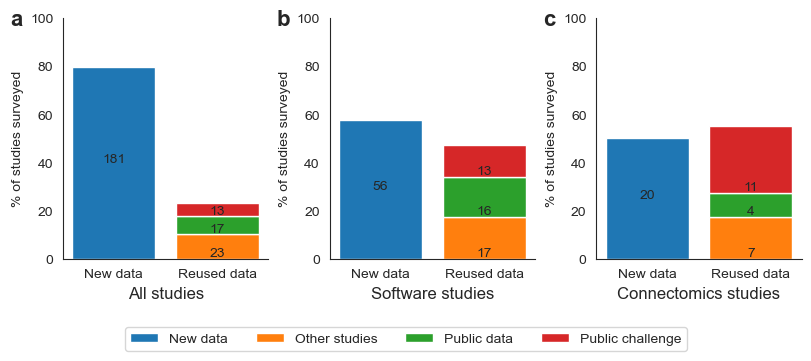

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), layout="constrained")
sns.set_style("white")
subfig_labels = ["a", "b", "c"]

for subplot, studytype in enumerate(["All", "Software", "Connectomics"]):
    study_df = origins_df[origins_df.StudyType == studytype]
    axs[subplot].bar(
        x=0,
        height=study_df.loc[study_df.Category == "Collected own data", "Percentage"],
    )
    axs[subplot].text(
        0,
        study_df.loc[study_df.Category == "Collected own data", "Percentage"].iloc[0] / 2,
        study_df[study_df.Category == 'Collected own data'].Count.iloc[0],
        horizontalalignment="center"
    )

    bottom = 0
    for i in ["Other studies", "Public data", "Public challenge"]:
        axs[subplot].bar(
            x=1,
            height=study_df.loc[study_df.Category == i, "Percentage"],
            bottom=bottom,
            label=i,
        )
        axs[subplot].text(
            1,
            bottom+1,
            study_df.loc[study_df.Category == i, 'Count'].iloc[0],
            horizontalalignment="center"
        )
        bottom += study_df.loc[study_df.Category == i, 'Percentage'].iloc[0]

    axs[subplot].set_ylim([0, 100])
    axs[subplot].set_xticks([0, 1], ["New data", "Reused data"])
    axs[subplot].set_xlabel(f"{studytype} studies", fontsize=12)
    axs[subplot].set_ylabel(r"% of studies surveyed")
    axs[subplot].text(-1, 97, subfig_labels[subplot], fontsize=16, fontweight="bold")

sns.despine()
plt.savefig("./figs/data_origins.svg")
fig.legend(
    ["New data", "Other studies", "Public data", "Public challenge"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=4
)

### Breakdown by imaging modality

In [14]:
# Categorise into X-ray, room-temp EM or cryoEM
modality_lookup = {
    '3D EM': ["Room-temp EM"],
    'ATUM SEM, FIB SEM': ["Room-temp EM"],
    'Cryo-EM': ["Cryo EM"],
    'Cryo-ET': ["Cryo EM"],
    'Cryo-FIB-SEM': ["Cryo EM"],
    'EM': ["Room-temp EM"],
    'Electron Tomography': ["Room-temp EM"],
    'Electron tomography': ["Room-temp EM"],
    'FIB SEM': ["Room-temp EM"],
    'FIB SEM, SBF SEM': ["Room-temp EM"],
    'FIB SEM, ssTEM': ["Room-temp EM"],
    'MicroCT': ["X-ray"],
    'MicroCT, CryoET': ["X-ray", "Cryo EM"],
    'MicroCT, FIBSEM, Electron tomography': ["X-ray", "Room-temp EM"],
    'MicroCT, Neutron imaging': ["X-ray"],
    'SBF SEM': ["Room-temp EM"],
    'SBF SEM ': ["Room-temp EM"],
    'SBF SEM, FIB SEM': ["Room-temp EM"],
    'SEM': ["Room-temp EM"],
    'Soft XCT': ["X-ray"],
    'Synchrotron X-ray microCT': ["X-ray"],
    'Synchrotron X-ray microCT, SEM': ["X-ray", "Room-temp EM"],
    'TEM': ["Room-temp EM"],
    'TEM, SEM': ["Room-temp EM"],
    'TEM, electron tomography, STEM': ["Room-temp EM"],
    'X-ray microCT': ["X-ray"],
    'X-ray microCT, FIB SEM': ["X-ray", "Room-temp EM"],
    'X-ray microCT, SEM': ["X-ray", "Room-temp EM"],
    'Cryo-ET & fluor': ["Cryo EM"],
    'ssSEM': ["Room-temp EM"],
    'ssTEM': ["Room-temp EM"],
    'ssTEM, SBF SEM': ["Room-temp EM"],
    'ssTEM, ssSEM, SBF SEM': ["Room-temp EM"],
    }

In [15]:
origins_mod = {}

for category in set(origin_lookup.values()):
    origins_mod[category] = {}
    for modality_category in ["Room-temp EM", "X-ray", "Cryo EM"]:
        origins_mod[category][modality_category] = 0

for i in range(len(df)):
    for value, category in origin_lookup.items():
        if value.lower() in df.DataOrigin.iloc[i].lower():
            try:
                modality_groups = modality_lookup[df.Modality.iloc[i]]
                for g in modality_groups:
                    origins_mod[category][g] += 1
            except:
                pass  # ignore papers which are not modality-specific

origins_mod_df = pd.DataFrame.from_dict(origins_mod, orient="index")
origins_mod_df["Category"] = origins_mod_df.index
origins_mod_df = origins_mod_df.melt(
    id_vars="Category",
    var_name="Modality",
    value_name="Count"
)
origins_mod_df.head()

,Category,Modality,Count
0,Public challenge,Room-temp EM,12
1,Public data,Room-temp EM,12
2,Unclear,Room-temp EM,2
3,Other studies,Room-temp EM,14
4,Collected own data,Room-temp EM,66


In [16]:
# Add percentages

origins_mod_df["Percentage"] = np.nan  # initialise values for percentage

for modality_category in ["Room-temp EM", "X-ray", "Cryo EM"]:
    each_df = origins_mod_df.loc[origins_mod_df.Modality == modality_category, "Count"]
    pct = 100 * each_df / each_df.sum()
    origins_mod_df.loc[origins_mod_df.Modality == modality_category, "Percentage"] = pct

origins_mod_df.head()

,Category,Modality,Count,Percentage
0,Public challenge,Room-temp EM,12,11.320755
1,Public data,Room-temp EM,12,11.320755
2,Unclear,Room-temp EM,2,1.886792
3,Other studies,Room-temp EM,14,13.207547
4,Collected own data,Room-temp EM,66,62.264151


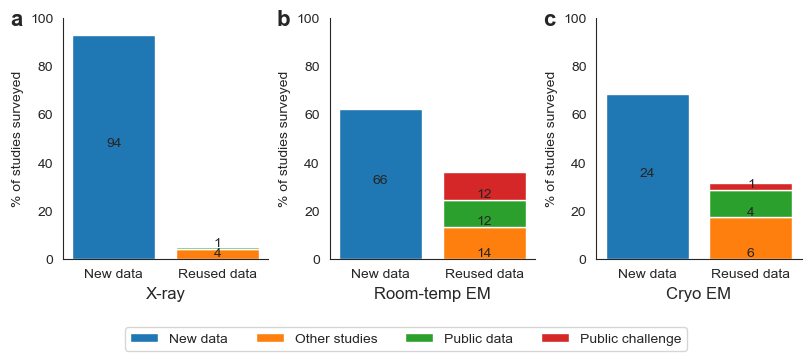

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), layout="constrained")
sns.set_style("white")
subfig_labels = ["a", "b", "c"]

for subplot, mod in enumerate(["X-ray", "Room-temp EM", "Cryo EM"]):
    mod_df = origins_mod_df[origins_mod_df.Modality == mod]
    axs[subplot].bar(
        x=0,
        height=mod_df.loc[mod_df.Category == "Collected own data", "Percentage"],
    )
    axs[subplot].text(
        0,
        mod_df.loc[mod_df.Category == "Collected own data", "Percentage"].iloc[0] / 2,
        mod_df[mod_df.Category == 'Collected own data'].Count.iloc[0],
        horizontalalignment="center"
    )

    bottom = 0
    for i in ["Other studies", "Public data", "Public challenge"]:
        axs[subplot].bar(
            x=1,
            height=mod_df.loc[mod_df.Category == i, "Percentage"],
            bottom=bottom,
            label=i,
        )
        if mod_df.loc[mod_df.Category == i, 'Count'].iloc[0] > 0:
            axs[subplot].text(
                1,
                bottom+1,
                mod_df.loc[mod_df.Category == i, 'Count'].iloc[0],
                horizontalalignment="center"
            )
        bottom += mod_df.loc[mod_df.Category == i, 'Percentage'].iloc[0]

    axs[subplot].set_ylim([0, 100])
    axs[subplot].set_xticks([0, 1], ["New data", "Reused data"])
    axs[subplot].set_xlabel(mod, fontsize=12)
    axs[subplot].set_ylabel(r"% of studies surveyed")
    axs[subplot].text(-1, 97, subfig_labels[subplot], fontsize=16, fontweight="bold")

sns.despine()
plt.savefig("./figs/data_origins_by_modality.svg")
fig.legend(
    ["New data", "Other studies", "Public data", "Public challenge"],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=4
)